# Cirq

In [1]:
import cirq
from cirq.contrib.svg import SVGCircuit

def get_cirq_compilation(qasm_qc, target):
    if "ibm" in target:
        pass
    elif "rigetti" in target:
        pass
    elif "ionq" in target:
        pass

ModuleNotFoundError: No module named 'cirq'

In [ ]:
from cirq.contrib.qasm_import import circuit_from_qasm
test = open('../MQTbench/mqt/bench/qasm_output/su2random_indep_4.qasm', 'r').read()
ion_circuit = cirq.ion.ConvertToIonGates().convert_circuit(circuit)
print(ion_circuit)

In [ ]:
import cirq_rigetti
c = cirq_rigetti.circuit_transformers.default(circuit=circuit)
print(c)

SVGCircuit(c[0])

In [ ]:
import cirq
import cirq_ionq as ionq
q0 = cirq.LineQubit(0)
device = ionq.IonQAPIDevice([q0])
circuit = cirq.Circuit(device=device)
circuit.append(cirq.H(q0)**0.2) # Non-IonQ-API gate
print(circuit) # will print the circuit converted into IonQ's target gateset

# Pennylane

In [ ]:
import pennylane as qml
from pennylane import numpy as np

In [ ]:
ibm_native_gates = FakeMontreal().configuration().basis_gates
rigetti_native_gates = ["rx", "rz", "cz"]
ibm_native_gates

dev = qml.device('default.qubit', wires=[0, 1, 2])
qnode = qml.QNode(qfunc, dev)
print(qml.draw(qnode)(0.2, 0.3, 0.4))

compiled_qfunc = qml.compile(basis_set=rigetti_native_gates)(qfunc)
compiled_qnode = qml.QNode(compiled_qfunc, dev)
print(qml.draw(compiled_qnode)(0.2, 0.3, 0.4))

In [ ]:
path_file = "../MQTbench/qasm_output/dj_indep_4.qasm"
with open (path_file, "r") as myfile:
    data = myfile.read()
my_circuit = qml.from_qasm(data)

n=4
dev = qml.device('default.qubit', wires=n)
@qml.qnode(dev)
def circuit():
    my_circuit(wires=tuple(range(n)))
    return [qml.expval(qml.PauliZ(i)) for i in range(n)]

#circuit()
#print(dev._circuit.qasm(formatted=True))

In [ ]:
pennylane_ibm=["RZ", "SX", "PauliX", "CNOT"]
pennylane_rigetti=["RX", "RZ", "CZ"]

In [ ]:
compiled_qfunc1 = qml.compile()(circuit)
compiled_qnode1 = qml.QNode(compiled_qfunc1, dev)
print(qml.draw(compiled_qnode1)())

compiled_qfunc2 = qml.compile(
    basis_set=["CNOT", "RX", "RY", "RZ"],
    num_passes=2
)(circuit)

compiled_qnode2 = qml.QNode(compiled_qfunc2, dev)
print(qml.draw(compiled_qnode2)())

In [ ]:
def qfunc(x, y, z):
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=2)
    qml.RZ(z, wires=2)
    qml.CNOT(wires=[2, 1])
    qml.RX(z, wires=0)
    qml.CNOT(wires=[1, 0])
    qml.RX(x, wires=0)
    qml.CNOT(wires=[1, 0])
    qml.RZ(-z, wires=2)
    qml.RX(y, wires=2)
    qml.PauliY(wires=2)
    qml.CY(wires=[1, 2])
    return qml.expval(qml.PauliZ(wires=0))

dev = qml.device('default.qubit', wires=[0, 1, 2])
qnode = qml.QNode(qfunc, dev)
print(qml.draw(qnode)(0.2, 0.3, 0.4))

compiled_qfunc = qml.compile(
    pipeline=[
        qml.transforms.commute_controlled(direction="left"),
        qml.transforms.merge_rotations(atol=1e-6),
        qml.transforms.cancel_inverses
    ],
    basis_set=["CNOT", "RX", "RY", "CZ"],
    num_passes=2
)(qfunc)

compiled_qnode = qml.QNode(compiled_qfunc, dev)
print(qml.draw(compiled_qnode)(0.2, 0.3, 0.4))

In [ ]:
def qfunc():
    qml.Hadamard(wires=0)    
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=2)
    qml.RZ(-0.4, wires=2)
    qml.CNOT(wires=[2, 1])
    qml.RX(-0.4, wires=0)
    qml.CNOT(wires=[1, 0])
    qml.RX(-0.4, wires=0)
    qml.CNOT(wires=[1, 0])
    qml.RZ(-0.4, wires=2)
    qml.RX(1, wires=2)
    qml.PauliY(wires=2)
    qml.CY(wires=[1, 2])
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

dev = qml.device('default.qubit', wires=[0, 1, 2])
qnode = qml.QNode(qfunc, dev)
print(qml.draw(qnode)())

compiled_qfunc = qml.compile(
    basis_set=["CNOT", "Rdawd", "wdfawdaw", "dawd"],
    num_passes=20
)(qfunc)

compiled_qnode = qml.QNode(compiled_qfunc, dev)
print(qml.draw(compiled_qnode)())

# Workflow Debugging

In [ ]:
from evaluator.evaluator import create_gate_lists
create_gate_lists(4, 120, 5, 20)

dj 4
measure gate not found in openQASM 2.0 gateset


/Users/nils/miniforge3/envs/tf3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/nils/miniforge3/envs/tf3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


dj 9
measure gate not found in openQASM 2.0 gateset
dj 14
measure gate not found in openQASM 2.0 gateset
dj 19
measure gate not found in openQASM 2.0 gateset
dj 24
measure gate not found in openQASM 2.0 gateset
dj 29
measure gate not found in openQASM 2.0 gateset
dj 34
measure gate not found in openQASM 2.0 gateset
dj 39
measure gate not found in openQASM 2.0 gateset
dj 44
measure gate not found in openQASM 2.0 gateset
dj 49
measure gate not found in openQASM 2.0 gateset
dj 54
measure gate not found in openQASM 2.0 gateset
dj 59
measure gate not found in openQASM 2.0 gateset
dj 64
measure gate not found in openQASM 2.0 gateset
dj 69
measure gate not found in openQASM 2.0 gateset
dj 74
measure gate not found in openQASM 2.0 gateset
dj 79
measure gate not found in openQASM 2.0 gateset
Calculation/Generation exceeded timeout limit for  <function get_tket_gates at 0x13f9874c0> []
grover-noancilla 4
measure gate not found in openQASM 2.0 gateset
barrier gate not found in openQASM 2.0 gatese

In [1]:
from evaluator.evaluator import extract_training_data_from_json, train_simple_ml_model
import numpy as np
training_data, qasm_list, name_list = extract_training_data_from_json("json_data.json")
print(name_list)

['dj_4', 'dj_7', 'dj_10', 'dj_13', 'dj_16', 'dj_19', 'dj_22', 'dj_25', 'dj_28', 'dj_31', 'dj_34', 'dj_37', 'dj_40', 'dj_43', 'dj_46', 'dj_49', 'grover-noancilla_4', 'grover-v-chain_4', 'ghz_4', 'ghz_7', 'ghz_10', 'ghz_13', 'ghz_16', 'ghz_19', 'ghz_22', 'ghz_25', 'ghz_28', 'ghz_31', 'ghz_34', 'ghz_37', 'ghz_40', 'ghz_43', 'ghz_46', 'ghz_49', 'graphstate_4', 'graphstate_7', 'graphstate_10', 'graphstate_13', 'graphstate_16', 'graphstate_19', 'graphstate_22', 'graphstate_25', 'graphstate_28', 'graphstate_31', 'graphstate_34', 'qft_4', 'qft_7', 'qft_10', 'qftentangled_4', 'qftentangled_7', 'qftentangled_10', 'qftentangled_13', 'qpeexact_4', 'qpeexact_7', 'qpeexact_10', 'qpeinexact_4', 'qpeinexact_7', 'qpeinexact_10', 'qwalk-noancilla_4', 'realamprandom_4', 'realamprandom_7', 'su2random_4', 'su2random_7', 'twolocalrandom_4', 'twolocalrandom_7', 'vqe_4', 'vqe_7', 'vqe_10', 'wstate_4', 'wstate_7', 'wstate_10', 'wstate_13', 'wstate_16', 'wstate_19', 'wstate_22', 'wstate_25', 'wstate_28', 'wstat

Metal device set to: Apple M1 Pro
Epoch 1/100


2022-04-11 14:12:18.805752: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-11 14:12:18.805872: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-04-11 14:12:18.887560: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


3/3 [==============================] - 0s 28ms/step - loss: 4.2529 - accuracy: 0.0923
Epoch 2/100
1/3 [=========>....................] - ETA: 0s - loss: 1.9149 - accuracy: 0.3750

2022-04-11 14:12:19.052161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 8ms/step - loss: 1.6697 - accuracy: 0.4000
Epoch 3/100
3/3 [==============================] - 0s 7ms/step - loss: 1.1732 - accuracy: 0.7385
Epoch 4/100
3/3 [==============================] - 0s 8ms/step - loss: 1.0456 - accuracy: 0.7385
Epoch 5/100
3/3 [==============================] - 0s 7ms/step - loss: 0.9472 - accuracy: 0.7692
Epoch 6/100
3/3 [==============================] - 0s 7ms/step - loss: 0.7953 - accuracy: 0.7692
Epoch 7/100
3/3 [==============================] - 0s 8ms/step - loss: 0.6457 - accuracy: 0.8000
Epoch 8/100
3/3 [==============================] - 0s 7ms/step - loss: 0.6792 - accuracy: 0.7538
Epoch 9/100
3/3 [==============================] - 0s 7ms/step - loss: 0.6296 - accuracy: 0.7538
Epoch 10/100
3/3 [==============================] - 0s 7ms/step - loss: 0.6581 - accuracy: 0.7385
Epoch 11/100
3/3 [==============================] - 0s 7ms/step - loss: 0.6871 - accuracy: 0.7692
Epoch 12/100
3/3 [======================

3/3 [==============================] - 0s 7ms/step - loss: 0.3383 - accuracy: 0.8462
Epoch 86/100
3/3 [==============================] - 0s 8ms/step - loss: 0.3296 - accuracy: 0.8462
Epoch 87/100
3/3 [==============================] - 0s 7ms/step - loss: 0.3242 - accuracy: 0.8615
Epoch 88/100
3/3 [==============================] - 0s 8ms/step - loss: 0.3203 - accuracy: 0.8462
Epoch 89/100
3/3 [==============================] - 0s 7ms/step - loss: 0.3198 - accuracy: 0.8462
Epoch 90/100
3/3 [==============================] - 0s 8ms/step - loss: 0.3175 - accuracy: 0.8462
Epoch 91/100
3/3 [==============================] - 0s 7ms/step - loss: 0.3130 - accuracy: 0.8462
Epoch 92/100
3/3 [==============================] - 0s 7ms/step - loss: 0.3200 - accuracy: 0.8923
Epoch 93/100
3/3 [==============================] - 0s 8ms/step - loss: 0.4372 - accuracy: 0.8000
Epoch 94/100
3/3 [==============================] - 0s 8ms/step - loss: 0.3541 - accuracy: 0.8615
Epoch 95/100
3/3 [===============

2022-04-11 14:12:21.702381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-11 14:12:21.819677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Accuracy on training data: 0.8153846263885498% 
 Error on training data: 0.1846153736114502
1/1 [==============================] - 0s 27ms/step - loss: 1.2685 - accuracy: 0.8571
Accuracy on test data: 0.8571429252624512% 
 Error on test data: 0.14285707473754883
qiskit_ionq qiskit_ibm_montreal 22
tket_ibm_washington tket_ibm_washington 16
qiskit_ionq qiskit_ionq 4
tket_ibm_washington tket_ibm_washington 16
qiskit_ionq qiskit_ionq 4
tket_ibm_washington tket_ibm_washington 28
qiskit_ionq qiskit_ibm_washington 19
qiskit_ionq qiskit_ionq 10
tket_ibm_washington tket_ibm_washington 34
qiskit_ionq qiskit_ibm_washington 34
tket_ibm_washington tket_ibm_washington 49
qiskit_ionq qiskit_ionq 7
qiskit_ionq qiskit_ionq 7
qiskit_ionq qiskit_ionq 7
tket_ibm_washington tket_ibm_washington 40
tket_ibm_washington tket_ibm_washington 16
qiskit_ionq qiskit_ionq 4
tket_ibm_washington tket_ibm_washington 34
qiskit_ionq qiskit_ionq 7
qiskit_ionq qiskit_ionq 4
tket_ibm_washington qiskit_ibm_washington 49
qisk

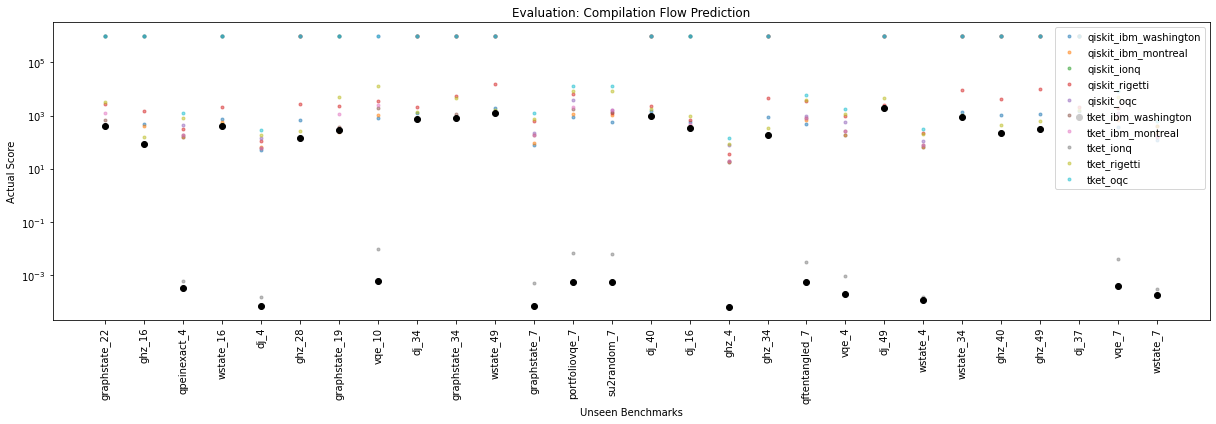

In [2]:
X, y = zip(*training_data)
train_simple_ml_model(X,y, True, True,qasm_list, name_list)

# TKET IonQ Custom Rebase Pass

In [ ]:
import pytket
from pytket import OpType, circuit, _tket, Circuit
from pytket.passes import RebaseCustom

In [ ]:
gates = {OpType.Rz, OpType.Ry, OpType.CY, OpType.ZZPhase}
cx_in_cy = Circuit(2)
cx_in_cy.Rz(0.5, 1).CY(0, 1).Rz(-0.5, 1)
def tk1_to_rzry(a, b, c):
    circ = Circuit(1)
    circ.Rz(c + 0.5, 0).Ry(b, 0).Rz(a - 0.5, 0)
    return circ

custom = RebaseCustom(gates, cx_in_cy, tk1_to_rzry)

circ = Circuit(3)
circ.X(0).CX(0, 1).Ry(0.2, 1)
circ.add_gate(OpType.ZZPhase, -0.83, [2, 1]).Rx(0.6, 2)

custom.apply(circ)

print(circ.get_commands())

In [ ]:
ionq_gateset = {OpType.Rz, OpType.Ry, OpType.XXPhase}
cx_in_ionq = _tket.circuit._library._CX_using_XXPhase_0()
def tk1_to_rzry(a, b, c):
    circ = Circuit(1)
    circ.Rz(c + 0.5, 0).Ry(b, 0).Rz(a - 0.5, 0)
    return circ
ionq_rebase = RebaseCustom(ionq_gateset, cx_in_ionq, tk1_to_rzry)

In [ ]:
circ = Circuit(3)
circ.X(0).CX(0, 1).Ry(0.2, 1)
circ.add_gate(OpType.ZZPhase, -0.83, [2, 1]).Rx(0.6, 2)

ionq_rebase.apply(circ)
print(circ.get_commands())

In [ ]:
from pytket._tket.circuit._library._CX_using_XXPhase_0()

In [ ]:
_library._CX_using_XXPhase_0()

# Testing/Debugging

In [ ]:
from evaluator import utils
from pytket.circuit.display import render_circuit_jupyter
from mqt.bench import benchmark_generator
import matplotlib.pyplot as plt
from evaluator.qiskit_plugin import *
from evaluator.pytket_plugin import *
import numpy as np
from pytket.extensions.qiskit import qiskit_to_tk
from qiskit import QuantumCircuit